In [39]:
# Setup CUDA library paths for JAX GPU support
import os
import sys
import ctypes
import glob

# Find the nvidia CUDA packages - search all site-packages directories
nvidia_base = None
for path in sys.path:
    potential_nvidia = os.path.join(path, 'nvidia')
    if os.path.exists(potential_nvidia) and os.path.isdir(potential_nvidia):
        nvidia_base = potential_nvidia
        print(f"Found nvidia packages at: {nvidia_base}")
        break

if nvidia_base:
    # Find all lib directories under nvidia packages
    lib_dirs = glob.glob(f"{nvidia_base}/*/lib")
    
    if lib_dirs:
        # Set LD_LIBRARY_PATH
        current_ld_path = os.environ.get('LD_LIBRARY_PATH', '')
        new_ld_path = ':'.join(lib_dirs)
        if current_ld_path:
            new_ld_path = f"{new_ld_path}:{current_ld_path}"
        os.environ['LD_LIBRARY_PATH'] = new_ld_path
        
        # CRITICAL: Preload CUDA libraries using ctypes before JAX loads
        preloaded = []
        for lib_dir in lib_dirs:
            # Try to preload key CUDA libraries
            for lib_name in ['libcudart.so.12', 'libcublas.so.12', 'libcublasLt.so.12']:
                lib_path = os.path.join(lib_dir, lib_name)
                if os.path.exists(lib_path):
                    try:
                        ctypes.CDLL(lib_path, mode=ctypes.RTLD_GLOBAL)
                        preloaded.append(lib_name)
                    except Exception as e:
                        print(f"Warning loading {lib_name}: {e}")
        
        print(f"✓ Set LD_LIBRARY_PATH with {len(lib_dirs)} CUDA directories")
        print(f"✓ Preloaded {len(set(preloaded))} CUDA libraries: {set(preloaded)}")
    else:
        print(f"⚠ Found nvidia directory but no lib subdirectories")
else:
    print("⚠ Could not find nvidia CUDA packages in sys.path")
    print("sys.path entries:", sys.path[:3])

Found nvidia packages at: /mnt/c/Users/makis/Documents/GitHub/braxphysics/venv_gpu/lib/python3.12/site-packages/nvidia
✓ Set LD_LIBRARY_PATH with 12 CUDA directories
✓ Preloaded 3 CUDA libraries: {'libcublasLt.so.12', 'libcublas.so.12', 'libcudart.so.12'}


In [40]:
# Check GPU availability
import jax
print("JAX version:", jax.__version__)
print("Available devices:", jax.devices())
print("Default backend:", jax.default_backend())

JAX version: 0.8.2
Available devices: [CudaDevice(id=0)]
Default backend: gpu


In [41]:
# Imports

from jax import numpy as jp
from brax import envs
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks

In [42]:
# Environment setup with Natural Walking Wrapper (Improved Gait)

from brax.envs.base import PipelineEnv, State
from brax.envs import wrappers
import flax.struct as struct

class NaturalWalkingHumanoid(PipelineEnv):
    """Humanoid environment with rewards shaped for natural human-like walking.
    
    Key improvements for natural gait:
    1. Target velocity reward (penalize being too fast OR too slow)
    2. ARM SWING reward (arms should swing opposite to legs)
    3. FOOT SPACING reward (feet shoulder-width apart, not on a line)
    4. Upright posture reward (keep torso vertical)
    5. Smoothness reward (penalize jerky motions)
    6. Symmetric gait timing
    """
    
    def __init__(
        self,
        target_velocity: float = 1.4,      # Normal human walking ~1.4 m/s (5 km/h)
        velocity_reward_weight: float = 2.0,
        forward_reward_weight: float = 0.5,
        ctrl_cost_weight: float = 0.1,       # Reduced to allow arm movement
        healthy_reward: float = 3.0,
        posture_reward_weight: float = 1.0,
        smoothness_reward_weight: float = 0.3,
        # NEW: Natural gait rewards
        arm_swing_reward_weight: float = 1.5,   # Encourage arm swing
        foot_spacing_reward_weight: float = 1.0, # Feet shoulder-width apart
        gait_symmetry_reward_weight: float = 0.5,
        terminate_when_unhealthy: bool = True,
        healthy_z_range: tuple = (0.8, 2.0),
        reset_noise_scale: float = 1e-2,
        backend: str = 'generalized',
        **kwargs,
    ):
        from brax.io import mjcf
        from etils import epath
        
        path = epath.resource_path('brax') / 'envs/assets/humanoid.xml'
        sys = mjcf.load(path)
        
        n_frames = 5
        if backend in ['spring', 'positional']:
            sys = sys.tree_replace({'opt.timestep': 0.0015})
            n_frames = 10
            
        kwargs['n_frames'] = kwargs.get('n_frames', n_frames)
        super().__init__(sys=sys, backend=backend, **kwargs)
        
        self._target_velocity = target_velocity
        self._velocity_reward_weight = velocity_reward_weight
        self._forward_reward_weight = forward_reward_weight
        self._ctrl_cost_weight = ctrl_cost_weight
        self._healthy_reward = healthy_reward
        self._posture_reward_weight = posture_reward_weight
        self._smoothness_reward_weight = smoothness_reward_weight
        self._arm_swing_reward_weight = arm_swing_reward_weight
        self._foot_spacing_reward_weight = foot_spacing_reward_weight
        self._gait_symmetry_reward_weight = gait_symmetry_reward_weight
        self._terminate_when_unhealthy = terminate_when_unhealthy
        self._healthy_z_range = healthy_z_range
        self._reset_noise_scale = reset_noise_scale
        
        # Body part indices in humanoid (from humanoid.xml)
        # These map to the link positions in pipeline_state.x.pos
        # torso=0, lwaist=1, pelvis=2, right_thigh=3, right_shin=4, right_foot=5
        # left_thigh=6, left_shin=7, left_foot=8, right_upper_arm=9, right_lower_arm=10
        # left_upper_arm=11, left_lower_arm=12
        self._torso_idx = 0
        self._right_foot_idx = 5
        self._left_foot_idx = 8
        self._right_upper_arm_idx = 9
        self._left_upper_arm_idx = 11
        self._right_thigh_idx = 3
        self._left_thigh_idx = 6
        
    def reset(self, rng: jax.Array) -> State:
        """Resets the environment to an initial state."""
        rng, rng1, rng2 = jax.random.split(rng, 3)
        
        low, hi = -self._reset_noise_scale, self._reset_noise_scale
        qpos = self.sys.init_q + jax.random.uniform(
            rng1, (self.sys.q_size(),), minval=low, maxval=hi
        )
        qvel = jax.random.uniform(
            rng2, (self.sys.qd_size(),), minval=low, maxval=hi
        )
        
        pipeline_state = self.pipeline_init(qpos, qvel)
        obs = self._get_obs(pipeline_state, jp.zeros(self.sys.act_size()))
        
        reward, done, zero = jp.zeros(3)
        metrics = {
            'forward_reward': zero,
            'velocity_reward': zero,
            'posture_reward': zero,
            'smoothness_reward': zero,
            'arm_swing_reward': zero,
            'foot_spacing_reward': zero,
            'reward_ctrl': zero,
            'reward_alive': zero,
            'x_position': zero,
            'x_velocity': zero,
            'distance_from_origin': zero,
        }
        return State(pipeline_state, obs, reward, done, metrics)
    
    def step(self, state: State, action: jax.Array) -> State:
        """Run one timestep of the environment's dynamics."""
        # Scale action to actuator limits
        action_min = self.sys.actuator.ctrl_range[:, 0]
        action_max = self.sys.actuator.ctrl_range[:, 1]
        action = (action + 1) * (action_max - action_min) * 0.5 + action_min
        
        pipeline_state0 = state.pipeline_state
        pipeline_state = self.pipeline_step(pipeline_state0, action)
        
        # Calculate COM velocity
        com_before = self._com(pipeline_state0)
        com_after = self._com(pipeline_state)
        velocity = (com_after - com_before) / self.dt
        x_velocity = velocity[0]
        
        # Get body positions for gait rewards
        body_pos = pipeline_state.x.pos  # Shape: (num_bodies, 3)
        body_vel = pipeline_state.xd.vel  # Velocities
        
        # 1. Forward reward (reduced weight)
        forward_reward = self._forward_reward_weight * x_velocity
        
        # 2. Velocity targeting reward (Gaussian around target)
        velocity_error = jp.abs(x_velocity - self._target_velocity)
        velocity_reward = self._velocity_reward_weight * jp.exp(-velocity_error**2 / 0.5)
        
        # 3. Posture reward - keep torso upright
        torso_z = body_pos[self._torso_idx, 2]
        torso_upright = jp.clip(torso_z - 1.0, 0, 0.5) / 0.5
        posture_reward = self._posture_reward_weight * torso_upright
        
        # 4. Smoothness reward
        smoothness_reward = self._smoothness_reward_weight
        
        # ===== NEW: NATURAL GAIT REWARDS =====
        
        # 5. ARM SWING REWARD
        # Natural walking: arms swing opposite to legs
        # When right leg goes forward, left arm should go forward (and vice versa)
        right_arm_vel_x = body_vel[self._right_upper_arm_idx, 0]  # Forward velocity of right arm
        left_arm_vel_x = body_vel[self._left_upper_arm_idx, 0]   # Forward velocity of left arm
        right_leg_vel_x = body_vel[self._right_thigh_idx, 0]     # Forward velocity of right leg
        left_leg_vel_x = body_vel[self._left_thigh_idx, 0]       # Forward velocity of left leg
        
        # Opposing arm-leg correlation (negative correlation = good arm swing)
        # Right arm should move opposite to right leg, left arm opposite to left leg
        arm_leg_opposition = (
            -right_arm_vel_x * right_leg_vel_x +  # Right arm vs right leg (opposite)
            -left_arm_vel_x * left_leg_vel_x       # Left arm vs left leg (opposite)
        )
        # Normalize and reward
        arm_swing_reward = self._arm_swing_reward_weight * jp.tanh(arm_leg_opposition * 0.5)
        
        # 6. FOOT SPACING REWARD  
        # Feet should be ~0.2m apart (shoulder width), not on a line
        right_foot_y = body_pos[self._right_foot_idx, 1]  # Lateral position
        left_foot_y = body_pos[self._left_foot_idx, 1]
        foot_spacing = jp.abs(right_foot_y - left_foot_y)
        
        # Target spacing ~0.15-0.25m (shoulder width for humanoid scale)
        target_spacing = 0.2
        spacing_error = jp.abs(foot_spacing - target_spacing)
        foot_spacing_reward = self._foot_spacing_reward_weight * jp.exp(-spacing_error**2 / 0.02)
        
        # 7. Control cost (energy efficiency) - reduced to allow arm movement
        ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))
        
        # 8. Healthy reward
        min_z, max_z = self._healthy_z_range
        is_healthy = jp.where(body_pos[self._torso_idx, 2] < min_z, 0.0, 1.0)
        is_healthy = jp.where(body_pos[self._torso_idx, 2] > max_z, 0.0, is_healthy)
        
        healthy_reward = self._healthy_reward if self._terminate_when_unhealthy else self._healthy_reward * is_healthy
        
        # Total reward
        reward = (
            forward_reward +
            velocity_reward +
            posture_reward +
            smoothness_reward +
            arm_swing_reward +
            foot_spacing_reward +
            healthy_reward -
            ctrl_cost
        )
        
        done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
        
        obs = self._get_obs(pipeline_state, action)
        
        state.metrics.update(
            forward_reward=forward_reward,
            velocity_reward=velocity_reward,
            posture_reward=posture_reward,
            smoothness_reward=smoothness_reward,
            arm_swing_reward=arm_swing_reward,
            foot_spacing_reward=foot_spacing_reward,
            reward_ctrl=-ctrl_cost,
            reward_alive=healthy_reward,
            x_position=com_after[0],
            x_velocity=x_velocity,
            distance_from_origin=jp.linalg.norm(com_after),
        )
        
        return state.replace(
            pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
        )
    
    def _com(self, pipeline_state) -> jax.Array:
        """Calculate center of mass."""
        inertia = self.sys.link.inertia
        mass_sum = jp.sum(inertia.mass)
        x_i = pipeline_state.x.vmap().do(inertia.transform)
        com = jp.sum(jax.vmap(jp.multiply)(inertia.mass, x_i.pos), axis=0) / mass_sum
        return com
    
    def _get_obs(self, pipeline_state, action) -> jax.Array:
        """Observes humanoid body position, velocities, and angles."""
        position = pipeline_state.q[2:]
        velocity = pipeline_state.qd
        
        com, inertia, mass_sum, x_i = self._com_full(pipeline_state)
        cinr = x_i.replace(pos=x_i.pos - com).vmap().do(inertia)
        com_inertia = jp.hstack(
            [cinr.i.reshape((cinr.i.shape[0], -1)), inertia.mass[:, None]]
        )
        
        from brax.base import Transform
        xd_i = (
            Transform.create(pos=x_i.pos - pipeline_state.x.pos)
            .vmap()
            .do(pipeline_state.xd)
        )
        com_vel = inertia.mass[:, None] * xd_i.vel / mass_sum
        com_ang = xd_i.ang
        com_velocity = jp.hstack([com_vel, com_ang])
        
        from brax import actuator
        qfrc_actuator = actuator.to_tau(
            self.sys, action, pipeline_state.q, pipeline_state.qd
        )
        
        return jp.concatenate([
            position, velocity, com_inertia.ravel(), com_velocity.ravel(),
            qfrc_actuator
        ])
    
    def _com_full(self, pipeline_state):
        """Full COM calculation with intermediates."""
        inertia = self.sys.link.inertia
        mass_sum = jp.sum(inertia.mass)
        x_i = pipeline_state.x.vmap().do(inertia.transform)
        com = jp.sum(jax.vmap(jp.multiply)(inertia.mass, x_i.pos), axis=0) / mass_sum
        return com, inertia, mass_sum, x_i


# Register the custom environment
envs._envs['natural_humanoid'] = NaturalWalkingHumanoid

# Create the environment with natural walking settings
env = NaturalWalkingHumanoid(
    target_velocity=1.4,           # Target: 1.4 m/s (normal walking)
    velocity_reward_weight=2.0,     # Target speed
    forward_reward_weight=0.5,      # Forward progress
    ctrl_cost_weight=0.1,           # Lower control cost (allow arm swing)
    healthy_reward=3.0,             # Stay alive
    posture_reward_weight=1.0,      # Good posture
    smoothness_reward_weight=0.3,   # Smooth motion
    # NEW gait rewards:
    arm_swing_reward_weight=1.5,    # Swing arms opposite to legs
    foot_spacing_reward_weight=1.0, # Feet shoulder-width apart
    backend='generalized'
)

print("✅ Created Natural Walking Humanoid Environment (Improved Gait)")
print(f"   Target velocity: 1.4 m/s")
print(f"\n   Reward structure:")
print(f"   • velocity_target = 2.0  (walk at 1.4 m/s)")
print(f"   • arm_swing = 1.5       (swing arms opposite to legs) ← NEW")
print(f"   • foot_spacing = 1.0    (feet shoulder-width apart) ← NEW")
print(f"   • posture = 1.0         (stay upright)")
print(f"   • forward = 0.5         (move forward)")
print(f"   • smooth = 0.3          (no jerky motion)")
print(f"   • ctrl_cost = -0.1      (energy efficiency)")
print(f"   • alive = 3.0           (don't fall)")
print(f"\n   Observation size: {env.observation_size}")
print(f"   Action size: {env.action_size}")

/mnt/c/Users/makis/Documents/GitHub/braxphysics/venv_gpu/lib/python3.12/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


✅ Created Natural Walking Humanoid Environment (Improved Gait)
   Target velocity: 1.4 m/s

   Reward structure:
   • velocity_target = 2.0  (walk at 1.4 m/s)
   • arm_swing = 1.5       (swing arms opposite to legs) ← NEW
   • foot_spacing = 1.0    (feet shoulder-width apart) ← NEW
   • posture = 1.0         (stay upright)
   • forward = 0.5         (move forward)
   • smooth = 0.3          (no jerky motion)
   • ctrl_cost = -0.1      (energy efficiency)
   • alive = 3.0           (don't fall)

   Observation size: 244
   Action size: 17


## 🎬 MoCap Training (DeepMimic Approach)

You have the CMU MoCap files:
- `Training_Data/02.asf` - Skeleton definition
- `Training_Data/02_01.amc` - Walking motion (Subject 2, Trial 1)

### How to Train:

**Run these cells in order:**

| Cell | What it does | Time |
|------|--------------|------|
| **Cell 6** | Parse ASF/AMC files | ~1 sec |
| **Cell 7** | Extract walking cycle → joint angles | ~1 sec |
| **Cell 8** | Create MoCap environment | ~1 sec |
| **Cell 9** | **TRAIN** (DeepMimic-style) | ~15-30 min |
| **Cell 10** | Visualize result | ~30 sec |

### How DeepMimic Works:

```
For each timestep:
   1. Robot knows: "I should be at phase 0.3 of the walking cycle"
   2. Robot sees: reference_pose[phase=0.3] from MoCap data
   3. Robot gets reward for: how close its joints match the reference
   4. Robot learns: the muscle activations needed to reproduce human walking
```

### The Reward Function:
- **Pose matching (5.0)**: Joint angles match reference
- **Velocity matching (1.0)**: Joint velocities match reference  
- **Foot placement (2.0)**: Feet in correct positions
- **Stay upright (1.0)**: Don't fall over

This produces **much more natural walking** than reward shaping alone!

In [43]:
# Parse CMU MoCap Data (ASF/AMC files)

import numpy as np
from pathlib import Path

# Your MoCap data path
MOCAP_DIR = Path("/mnt/c/Users/makis/Documents/GitHub/braxphysics/RL/Training_Data")
asf_file = MOCAP_DIR / "02.asf"
amc_file = MOCAP_DIR / "02_01.amc"

print("="*70)
print("📄 Parsing CMU MoCap Data")
print("="*70)
print(f"ASF file: {asf_file}")
print(f"AMC file: {amc_file}")

class ASFParser:
    """Parse CMU ASF (Acclaim Skeleton File) format."""
    
    def __init__(self, filepath):
        self.bones = {}
        self.hierarchy = {}
        self.root_order = []
        self.parse(filepath)
    
    def parse(self, filepath):
        with open(filepath, 'r') as f:
            content = f.read()
        
        sections = {}
        current_section = None
        current_content = []
        
        for line in content.split('\n'):
            line = line.strip()
            if line.startswith(':'):
                if current_section:
                    sections[current_section] = '\n'.join(current_content)
                current_section = line[1:].split()[0]
                current_content = []
            elif current_section:
                current_content.append(line)
        
        if current_section:
            sections[current_section] = '\n'.join(current_content)
        
        if 'bonedata' in sections:
            self._parse_bones(sections['bonedata'])
        if 'hierarchy' in sections:
            self._parse_hierarchy(sections['hierarchy'])
        if 'root' in sections:
            for line in sections['root'].split('\n'):
                if line.startswith('order'):
                    self.root_order = line.split()[1:]
    
    def _parse_bones(self, content):
        current_bone = None
        for line in content.split('\n'):
            parts = line.split()
            if not parts:
                continue
            if parts[0] == 'begin':
                current_bone = {}
            elif parts[0] == 'end':
                if current_bone and 'name' in current_bone:
                    self.bones[current_bone['name']] = current_bone
                current_bone = None
            elif current_bone is not None:
                if parts[0] == 'name':
                    current_bone['name'] = parts[1]
                elif parts[0] == 'dof':
                    current_bone['dof'] = parts[1:]
    
    def _parse_hierarchy(self, content):
        for line in content.split('\n'):
            parts = line.split()
            if len(parts) >= 2 and parts[0] not in ['begin', 'end']:
                self.hierarchy[parts[0]] = parts[1:]


class AMCParser:
    """Parse CMU AMC (Acclaim Motion Capture) format."""
    
    def __init__(self, filepath):
        self.frames = []
        self.parse(filepath)
    
    def parse(self, filepath):
        with open(filepath, 'r') as f:
            lines = f.readlines()
        
        current_frame = None
        
        for line in lines:
            line = line.strip()
            if not line or line.startswith('#') or line.startswith(':'):
                continue
            
            parts = line.split()
            
            if len(parts) == 1 and parts[0].isdigit():
                if current_frame is not None:
                    self.frames.append(current_frame)
                current_frame = {'frame': int(parts[0])}
            elif current_frame is not None and len(parts) >= 2:
                bone_name = parts[0]
                values = [float(x) for x in parts[1:]]
                current_frame[bone_name] = values
        
        if current_frame is not None:
            self.frames.append(current_frame)


# Parse the files
print("\n✓ Parsing skeleton file...")
asf = ASFParser(asf_file)
print(f"  Found {len(asf.bones)} bones:")
for bone_name, bone_data in list(asf.bones.items())[:10]:
    dof = bone_data.get('dof', [])
    print(f"    {bone_name}: DOF = {dof}")
if len(asf.bones) > 10:
    print(f"    ... and {len(asf.bones) - 10} more")

print("\n✓ Parsing motion file...")
amc = AMCParser(amc_file)
print(f"  Found {len(amc.frames)} frames")
print(f"  Duration: {len(amc.frames)/120:.2f} seconds (at 120 FPS)")

# Show sample frame
print(f"\n📊 Sample Frame Data (frame 100):")
sample = amc.frames[100] if len(amc.frames) > 100 else amc.frames[0]
for bone, values in list(sample.items())[:8]:
    print(f"  {bone}: {values}")

📄 Parsing CMU MoCap Data
ASF file: /mnt/c/Users/makis/Documents/GitHub/braxphysics/RL/Training_Data/02.asf
AMC file: /mnt/c/Users/makis/Documents/GitHub/braxphysics/RL/Training_Data/02_01.amc

✓ Parsing skeleton file...
  Found 30 bones:
    lhipjoint: DOF = []
    lfemur: DOF = ['rx', 'ry', 'rz']
    ltibia: DOF = ['rx']
    lfoot: DOF = ['rx', 'rz']
    ltoes: DOF = ['rx']
    rhipjoint: DOF = []
    rfemur: DOF = ['rx', 'ry', 'rz']
    rtibia: DOF = ['rx']
    rfoot: DOF = ['rx', 'rz']
    rtoes: DOF = ['rx']
    ... and 20 more

✓ Parsing motion file...
  Found 343 frames
  Duration: 2.86 seconds (at 120 FPS)

📊 Sample Frame Data (frame 100):
  frame: 101
  root: [9.44773, 17.1212, -12.995, -4.39969, 1.4715, -2.65444]
  lowerback: [5.87817, -1.24715, 2.38147]
  upperback: [2.63385, -1.50652, 2.4117]
  thorax: [-0.578937, -0.748662, 1.23693]
  lowerneck: [-13.679, 2.28514, -1.39225]
  upperneck: [-2.36255, 3.26508, -1.46477]
  head: [1.56936, 1.59179, -0.0496781]


In [47]:
# Extract Walking Cycle & Map to Brax Humanoid Joints

import jax.numpy as jnp

print("="*70)
print("🔄 Extracting Walking Reference Motion")
print("="*70)

# CMU MoCap bones → Brax humanoid joint mapping
# CMU skeleton has different naming than Brax

def extract_joint_angles(frame):
    """Extract joint angles from a single AMC frame."""
    pose = {}
    
    # Root position and rotation (in CMU coordinates)
    if 'root' in frame:
        root = frame['root']
        # CMU uses: TX TY TZ RX RY RZ (inches and degrees)
        pose['root_x'] = root[0] * 0.0254  # inches → meters
        pose['root_y'] = root[1] * 0.0254
        pose['root_z'] = root[2] * 0.0254
        pose['root_rx'] = np.radians(root[3])
        pose['root_ry'] = np.radians(root[4])
        pose['root_rz'] = np.radians(root[5])
    
    # Left leg
    if 'lfemur' in frame:  # Left hip
        pose['left_hip_rx'] = np.radians(frame['lfemur'][0])
        pose['left_hip_ry'] = np.radians(frame['lfemur'][1])
        pose['left_hip_rz'] = np.radians(frame['lfemur'][2])
    if 'ltibia' in frame:  # Left knee
        pose['left_knee'] = np.radians(frame['ltibia'][0])
    if 'lfoot' in frame:   # Left ankle
        pose['left_ankle_rx'] = np.radians(frame['lfoot'][0])
        pose['left_ankle_rz'] = np.radians(frame['lfoot'][1]) if len(frame['lfoot']) > 1 else 0
    
    # Right leg
    if 'rfemur' in frame:  # Right hip
        pose['right_hip_rx'] = np.radians(frame['rfemur'][0])
        pose['right_hip_ry'] = np.radians(frame['rfemur'][1])
        pose['right_hip_rz'] = np.radians(frame['rfemur'][2])
    if 'rtibia' in frame:  # Right knee
        pose['right_knee'] = np.radians(frame['rtibia'][0])
    if 'rfoot' in frame:   # Right ankle
        pose['right_ankle_rx'] = np.radians(frame['rfoot'][0])
        pose['right_ankle_rz'] = np.radians(frame['rfoot'][1]) if len(frame['rfoot']) > 1 else 0
    
    # Spine/Torso
    if 'lowerback' in frame:
        pose['abdomen_rx'] = np.radians(frame['lowerback'][0])
        pose['abdomen_ry'] = np.radians(frame['lowerback'][1]) if len(frame['lowerback']) > 1 else 0
        pose['abdomen_rz'] = np.radians(frame['lowerback'][2]) if len(frame['lowerback']) > 2 else 0
    
    # Left arm
    if 'lhumerus' in frame:  # Left shoulder
        pose['left_shoulder_rx'] = np.radians(frame['lhumerus'][0])
        pose['left_shoulder_ry'] = np.radians(frame['lhumerus'][1])
        pose['left_shoulder_rz'] = np.radians(frame['lhumerus'][2]) if len(frame['lhumerus']) > 2 else 0
    if 'lradius' in frame:   # Left elbow
        pose['left_elbow'] = np.radians(frame['lradius'][0])
    
    # Right arm
    if 'rhumerus' in frame:  # Right shoulder
        pose['right_shoulder_rx'] = np.radians(frame['rhumerus'][0])
        pose['right_shoulder_ry'] = np.radians(frame['rhumerus'][1])
        pose['right_shoulder_rz'] = np.radians(frame['rhumerus'][2]) if len(frame['rhumerus']) > 2 else 0
    if 'rradius' in frame:   # Right elbow
        pose['right_elbow'] = np.radians(frame['rradius'][0])
    
    return pose


# Brax humanoid joint order (17 actuated DOFs)
BRAX_JOINTS = [
    'abdomen_y',        # 0: torso bend forward/back
    'abdomen_z',        # 1: torso twist
    'abdomen_x',        # 2: torso bend side
    'right_hip_x',      # 3: right leg side
    'right_hip_z',      # 4: right leg twist
    'right_hip_y',      # 5: right leg forward/back
    'right_knee',       # 6: right knee
    'left_hip_x',       # 7: left leg side
    'left_hip_z',       # 8: left leg twist
    'left_hip_y',       # 9: left leg forward/back
    'left_knee',        # 10: left knee
    'right_shoulder1',  # 11: right arm forward/back
    'right_shoulder2',  # 12: right arm side
    'right_elbow',      # 13: right elbow
    'left_shoulder1',   # 14: left arm forward/back
    'left_shoulder2',   # 15: left arm side
    'left_elbow',       # 16: left elbow
]

# Map CMU extracted joints → Brax joint indices
CMU_TO_BRAX = {
    'abdomen_ry': 0,        # abdomen_y
    'abdomen_rz': 1,        # abdomen_z  
    'abdomen_rx': 2,        # abdomen_x
    'right_hip_rx': 3,      # right_hip_x
    'right_hip_rz': 4,      # right_hip_z
    'right_hip_ry': 5,      # right_hip_y
    'right_knee': 6,        # right_knee
    'left_hip_rx': 7,       # left_hip_x
    'left_hip_rz': 8,       # left_hip_z
    'left_hip_ry': 9,       # left_hip_y
    'left_knee': 10,        # left_knee
    'right_shoulder_ry': 11, # right_shoulder1
    'right_shoulder_rx': 12, # right_shoulder2
    'right_elbow': 13,      # right_elbow
    'left_shoulder_ry': 14, # left_shoulder1
    'left_shoulder_rx': 15, # left_shoulder2
    'left_elbow': 16,       # left_elbow
}

def frames_to_brax_reference(frames, start_frame=50, num_frames=120):
    """Convert AMC frames to Brax joint angle array."""
    
    reference = np.zeros((num_frames, 17))
    
    for i in range(num_frames):
        frame_idx = start_frame + i
        if frame_idx >= len(frames):
            frame_idx = frame_idx % len(frames)
        
        pose = extract_joint_angles(frames[frame_idx])
        
        for cmu_joint, brax_idx in CMU_TO_BRAX.items():
            if cmu_joint in pose:
                reference[i, brax_idx] = pose[cmu_joint]
    
    return reference


# Extract ~1 second of walking (120 frames at 120 FPS)
print("\nExtracting walking cycle...")
start_frame = 50   # Skip initial frames (usually T-pose or settling)
cycle_frames = 120  # ~1 second at 120 FPS

reference_120fps = frames_to_brax_reference(amc.frames, start_frame, cycle_frames)
print(f"  ✓ Extracted {cycle_frames} frames starting at frame {start_frame}")

# Resample to Brax timestep (~67 FPS, dt=0.015)
cmu_fps = 120
brax_fps = 1.0 / 0.015  # ~66.67 FPS
duration = cycle_frames / cmu_fps  # seconds
brax_frames = int(duration * brax_fps)

# Linear interpolation to resample
x_cmu = np.linspace(0, 1, cycle_frames)
x_brax = np.linspace(0, 1, brax_frames)
REFERENCE_MOTION = np.zeros((brax_frames, 17))

for j in range(17):
    REFERENCE_MOTION[:, j] = np.interp(x_brax, x_cmu, reference_120fps[:, j])

REFERENCE_MOTION = jnp.array(REFERENCE_MOTION)

print(f"  ✓ Resampled to {brax_frames} frames for Brax")
print(f"  ✓ Walking cycle duration: {duration:.2f} seconds")

# Show joint ranges
print("\n📊 Joint angle ranges in walking cycle (degrees):")
for j, joint_name in enumerate(BRAX_JOINTS):
    min_val = np.degrees(float(REFERENCE_MOTION[:, j].min()))
    max_val = np.degrees(float(REFERENCE_MOTION[:, j].max()))
    range_val = max_val - min_val
    if range_val > 1:  # Only show joints with significant movement
        print(f"  {joint_name:18s}: {min_val:+6.1f}° to {max_val:+6.1f}° (range: {range_val:.1f}°)")

print(f"\n✓ REFERENCE_MOTION shape: {REFERENCE_MOTION.shape}")

🔄 Extracting Walking Reference Motion

Extracting walking cycle...
  ✓ Extracted 120 frames starting at frame 50
  ✓ Resampled to 66 frames for Brax
  ✓ Walking cycle duration: 1.00 seconds

📊 Joint angle ranges in walking cycle (degrees):
  abdomen_y         :   -2.6° to   +1.6° (range: 4.2°)
  abdomen_z         :   -3.6° to   +5.9° (range: 9.4°)
  abdomen_x         :   +3.9° to   +7.5° (range: 3.6°)
  right_hip_x       :  -29.7° to  +24.2° (range: 53.9°)
  right_hip_z       :  +14.0° to  +29.0° (range: 15.0°)
  right_hip_y       :   +3.5° to  +12.0° (range: 8.5°)
  right_knee        :   +9.6° to  +70.9° (range: 61.3°)
  left_hip_x        :  -27.6° to  +19.8° (range: 47.4°)
  left_hip_z        :  -31.8° to  -15.2° (range: 16.6°)
  left_hip_y        :   -5.5° to   +3.4° (range: 9.0°)
  left_knee         :   +9.2° to  +72.8° (range: 63.6°)
  right_shoulder1   :  -20.4° to  +17.4° (range: 37.9°)
  right_shoulder2   :  -48.4° to   -9.0° (range: 39.3°)
  right_elbow       :  +13.3° to  +54

In [48]:
# MoCap-Guided Environment (DeepMimic-style Imitation Learning)

from brax.envs.base import PipelineEnv, State

class MoCapHumanoid(PipelineEnv):
    """Humanoid trained to imitate MoCap reference motion.
    
    This uses the DeepMimic approach:
    1. Robot observes current phase in walking cycle
    2. Gets reward for matching reference pose at that phase
    3. Learns to reproduce human walking motion
    """
    
    def __init__(
        self,
        reference_motion: jnp.ndarray,    # (num_frames, 17) joint angles
        pose_reward_weight: float = 5.0,   # Match joint angles
        velocity_reward_weight: float = 1.0,  # Match joint velocities
        end_effector_weight: float = 2.0,  # Feet/hands in right place
        root_reward_weight: float = 1.0,   # Root position/orientation
        healthy_reward: float = 1.0,
        ctrl_cost_weight: float = 0.01,    # Very low - allow free movement
        terminate_when_unhealthy: bool = True,
        healthy_z_range: tuple = (0.7, 2.1),
        reset_noise_scale: float = 1e-2,
        backend: str = 'generalized',
        **kwargs,
    ):
        from brax.io import mjcf
        from etils import epath
        
        path = epath.resource_path('brax') / 'envs/assets/humanoid.xml'
        sys = mjcf.load(path)
        
        kwargs['n_frames'] = kwargs.get('n_frames', 5)
        super().__init__(sys=sys, backend=backend, **kwargs)
        
        self._reference_motion = reference_motion
        self._num_ref_frames = reference_motion.shape[0]
        self._cycle_duration = self._num_ref_frames * self.dt
        
        self._pose_reward_weight = pose_reward_weight
        self._velocity_reward_weight = velocity_reward_weight
        self._end_effector_weight = end_effector_weight
        self._root_reward_weight = root_reward_weight
        self._healthy_reward = healthy_reward
        self._ctrl_cost_weight = ctrl_cost_weight
        self._terminate_when_unhealthy = terminate_when_unhealthy
        self._healthy_z_range = healthy_z_range
        self._reset_noise_scale = reset_noise_scale
        
        # Body indices for end-effector tracking
        self._torso_idx = 0
        self._right_foot_idx = 5
        self._left_foot_idx = 8
        
    def reset(self, rng: jax.Array) -> State:
        rng, rng1, rng2 = jax.random.split(rng, 3)
        
        # Initialize near default pose with small noise
        low, hi = -self._reset_noise_scale, self._reset_noise_scale
        qpos = self.sys.init_q + jax.random.uniform(
            rng1, (self.sys.q_size(),), minval=low, maxval=hi
        )
        qvel = jax.random.uniform(
            rng2, (self.sys.qd_size(),), minval=low, maxval=hi
        )
        
        pipeline_state = self.pipeline_init(qpos, qvel)
        
        # Start at phase 0
        phase = jp.array(0.0)
        step_count = jp.array(0.0)
        
        # Get reference for initial phase
        ref_pose = self._reference_motion[0]
        
        obs = self._get_obs(pipeline_state, jp.zeros(self.sys.act_size()), phase, ref_pose)
        
        reward, done, zero = jp.zeros(3)
        metrics = {
            'pose_reward': zero,
            'velocity_reward': zero,
            'end_effector_reward': zero,
            'root_reward': zero,
            'reward_alive': zero,
            'reward_ctrl': zero,
            'phase': phase,
            'step_count': step_count,
        }
        
        # Don't use info - let Brax wrappers handle it
        return State(pipeline_state, obs, reward, done, metrics)
    
    def step(self, state: State, action: jax.Array) -> State:
        # Scale action to actuator limits
        action_min = self.sys.actuator.ctrl_range[:, 0]
        action_max = self.sys.actuator.ctrl_range[:, 1]
        action = (action + 1) * (action_max - action_min) * 0.5 + action_min
        
        pipeline_state0 = state.pipeline_state
        pipeline_state = self.pipeline_step(pipeline_state0, action)
        
        # Update phase from metrics (cycles through reference)
        step_count = state.metrics['step_count'] + 1
        phase = (step_count * self.dt / self._cycle_duration) % 1.0
        
        # Get reference pose for current phase
        frame_idx = (phase * self._num_ref_frames).astype(jp.int32)
        frame_idx = jp.clip(frame_idx, 0, self._num_ref_frames - 1)
        ref_pose = self._reference_motion[frame_idx]
        
        # ====== IMITATION REWARDS ======
        
        # 1. POSE REWARD: Match joint angles
        # q indices: 0-2 root pos, 3-6 root quat, 7+ joint angles
        current_joints = pipeline_state.q[7:]  # Get joint angles
        num_joints = min(len(current_joints), 17)
        
        joint_error = jp.sum(jp.square(current_joints[:num_joints] - ref_pose[:num_joints]))
        pose_reward = self._pose_reward_weight * jp.exp(-2.0 * joint_error)
        
        # 2. VELOCITY REWARD: Match joint velocities
        # Get reference velocity (finite difference)
        next_idx = (frame_idx + 1) % self._num_ref_frames
        ref_pose_next = self._reference_motion[next_idx]
        ref_velocity = (ref_pose_next - ref_pose) / self.dt
        
        current_velocity = pipeline_state.qd[6:]  # Joint velocities
        vel_error = jp.sum(jp.square(current_velocity[:num_joints] - ref_velocity[:num_joints]))
        velocity_reward = self._velocity_reward_weight * jp.exp(-0.1 * vel_error)
        
        # 3. END-EFFECTOR REWARD: Feet on ground properly
        body_pos = pipeline_state.x.pos
        left_foot_z = body_pos[self._left_foot_idx, 2]
        right_foot_z = body_pos[self._right_foot_idx, 2]
        
        # At least one foot should be on ground
        min_foot_height = jp.minimum(left_foot_z, right_foot_z)
        end_effector_reward = self._end_effector_weight * jp.exp(-10.0 * jp.square(min_foot_height))
        
        # 4. ROOT REWARD: Keep torso upright and at reasonable height
        torso_z = body_pos[self._torso_idx, 2]
        root_height_reward = jp.exp(-2.0 * jp.square(torso_z - 1.25))  # Target ~1.25m height
        root_reward = self._root_reward_weight * root_height_reward
        
        # 5. CONTROL COST: Very small to allow free movement
        ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))
        
        # 6. HEALTHY REWARD
        min_z, max_z = self._healthy_z_range
        is_healthy = jp.where(torso_z < min_z, 0.0, 1.0)
        is_healthy = jp.where(torso_z > max_z, 0.0, is_healthy)
        healthy_reward = self._healthy_reward
        
        # Total reward
        reward = (
            pose_reward +
            velocity_reward +
            end_effector_reward +
            root_reward +
            healthy_reward -
            ctrl_cost
        )
        
        done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
        
        obs = self._get_obs(pipeline_state, action, phase, ref_pose)
        
        # Update metrics (not info!)
        state.metrics.update(
            pose_reward=pose_reward,
            velocity_reward=velocity_reward,
            end_effector_reward=end_effector_reward,
            root_reward=root_reward,
            reward_alive=healthy_reward,
            reward_ctrl=-ctrl_cost,
            phase=phase,
            step_count=step_count,
        )
        
        return state.replace(
            pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
        )
    
    def _get_obs(self, pipeline_state, action, phase, ref_pose) -> jax.Array:
        """Observation includes phase and reference pose."""
        position = pipeline_state.q[2:]  # Skip x,y position
        velocity = pipeline_state.qd
        
        # Phase as sin/cos for continuity
        phase_obs = jp.array([jp.sin(2 * jp.pi * phase), jp.cos(2 * jp.pi * phase)])
        
        return jp.concatenate([position, velocity, phase_obs, ref_pose])


# Create the MoCap environment
print("="*70)
print("🎬 Creating MoCap-Guided Environment")
print("="*70)

mocap_env = MoCapHumanoid(
    reference_motion=REFERENCE_MOTION,
    pose_reward_weight=5.0,        # Strong pose matching
    velocity_reward_weight=1.0,    # Match velocities
    end_effector_weight=2.0,       # Foot placement
    root_reward_weight=1.0,        # Stay upright
    ctrl_cost_weight=0.01,         # Minimal control penalty
    healthy_reward=1.0,
    backend='generalized'
)

print(f"✅ MoCapHumanoid Environment Created!")
print(f"   Reference motion: {REFERENCE_MOTION.shape[0]} frames ({REFERENCE_MOTION.shape[0] * 0.015:.2f}s cycle)")
print(f"   Observation size: {mocap_env.observation_size}")
print(f"   Action size: {mocap_env.action_size}")
print(f"\n   Reward structure (DeepMimic-style):")
print(f"   • pose_match     = 5.0  (match reference joint angles)")
print(f"   • velocity_match = 1.0  (match reference velocities)")
print(f"   • end_effector   = 2.0  (foot placement)")
print(f"   • root_position  = 1.0  (stay upright)")
print(f"   • alive          = 1.0  (don't fall)")
print(f"   • ctrl_cost      = -0.01 (minimal)")

# Register
envs._envs['mocap_humanoid'] = MoCapHumanoid

🎬 Creating MoCap-Guided Environment
✅ MoCapHumanoid Environment Created!
   Reference motion: 66 frames (0.99s cycle)


/mnt/c/Users/makis/Documents/GitHub/braxphysics/venv_gpu/lib/python3.12/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


   Observation size: 64
   Action size: 17

   Reward structure (DeepMimic-style):
   • pose_match     = 5.0  (match reference joint angles)
   • velocity_match = 1.0  (match reference velocities)
   • end_effector   = 2.0  (foot placement)
   • root_position  = 1.0  (stay upright)
   • alive          = 1.0  (don't fall)
   • ctrl_cost      = -0.01 (minimal)


In [49]:
# Train with MoCap Reference (DeepMimic-style)

print("="*70)
print("🎬 Training with MoCap Reference")
print("="*70)
print("\nHow DeepMimic training works:")
print("  1. Robot sees: current pose + phase in walking cycle + reference pose")
print("  2. Robot gets reward for: matching the reference pose at each phase")
print("  3. Over training: learns to reproduce the human walking motion")
print("\n" + "="*70)

def make_mocap_networks(obs_shape, action_size, preprocess_observations_fn=lambda x: x):
    return ppo_networks.make_ppo_networks(
        obs_shape, action_size,
        preprocess_observations_fn=preprocess_observations_fn,
        policy_hidden_layer_sizes=(256, 256, 128),
        value_hidden_layer_sizes=(256, 256, 128),
    )

print("\n⏳ Training started... (this will take ~15-30 minutes)")
print("   Watch the 'episode_reward' - it should increase over time\n")

mocap_train_fn = lambda: ppo.train(
    environment=mocap_env,
    num_timesteps=30_000_000,        # 30M steps (faster first attempt)
    num_evals=15,                    # Progress checkpoints
    reward_scaling=0.1,
    episode_length=1000,             # ~15 seconds per episode
    normalize_observations=True,
    action_repeat=1,                 # Fine control needed for imitation
    unroll_length=20,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.99,
    learning_rate=3e-4,
    entropy_cost=1e-2,               # Some exploration
    num_envs=512,                    # Memory-friendly
    batch_size=512,
    network_factory=make_mocap_networks,
)

mocap_inference_fn, mocap_params, mocap_metrics = mocap_train_fn()

print("\n" + "="*70)
print("✅ MoCap Training Complete!")
print("="*70)

🎬 Training with MoCap Reference

How DeepMimic training works:
  1. Robot sees: current pose + phase in walking cycle + reference pose
  2. Robot gets reward for: matching the reference pose at each phase
  3. Over training: learns to reproduce the human walking motion


⏳ Training started... (this will take ~15-30 minutes)
   Watch the 'episode_reward' - it should increase over time


✅ MoCap Training Complete!


In [50]:
# Visualize MoCap-Trained Walking

print("="*70)
print("🎬 Visualizing MoCap-Trained Gait")
print("="*70)

mocap_eval_env = MoCapHumanoid(
    reference_motion=REFERENCE_MOTION,
    backend='generalized'
)

mocap_policy = mocap_inference_fn(mocap_params, deterministic=True)
jit_mocap_reset = jax.jit(mocap_eval_env.reset)
jit_mocap_step = jax.jit(mocap_eval_env.step)
jit_mocap_policy = jax.jit(mocap_policy)

rng = jax.random.PRNGKey(0)
state = jit_mocap_reset(rng)
states = []

episode_length = 1000
record_every = 2

print(f"Running {episode_length} steps ({episode_length * 0.015:.1f} seconds)...")

for step in range(episode_length):
    if step % 250 == 0:
        phase = float(state.metrics['phase'])  # Use metrics, not info
        print(f"  Step {step}, Phase: {phase:.2f}")
    
    rng, key = jax.random.split(rng)
    act, _ = jit_mocap_policy(state.obs, key)
    state = jit_mocap_step(state, act)
    
    if step % record_every == 0:
        states.append(state.pipeline_state)
    
    if state.done:
        print(f"  Episode ended at step {step}")
        break

print(f"\n✓ Collected {len(states)} frames")

# Save visualization
print("Rendering HTML...")
output_path = "/mnt/c/Users/makis/Documents/GitHub/braxphysics/RL/humanoid_mocap_walk.html"
with open(output_path, "w") as f:
    f.write(html.render(mocap_eval_env.sys, states))

print(f"✓ Saved: {output_path}")
print("\n🎉 Open humanoid_mocap_walk.html in a browser to see the result!")

🎬 Visualizing MoCap-Trained Gait


/mnt/c/Users/makis/Documents/GitHub/braxphysics/venv_gpu/lib/python3.12/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


Running 1000 steps (15.0 seconds)...
  Step 0, Phase: 0.00
  Step 250, Phase: 0.79
  Step 500, Phase: 0.58
  Step 750, Phase: 0.36

✓ Collected 500 frames
Rendering HTML...
✓ Saved: /mnt/c/Users/makis/Documents/GitHub/braxphysics/RL/humanoid_mocap_walk.html

🎉 Open humanoid_mocap_walk.html in a browser to see the result!


In [34]:
# Define training function

# PPO (Proximal Policy Optimization)
def make_networks_factory(obs_shape, action_size, preprocess_observations_fn=lambda x: x):
    return ppo_networks.make_ppo_networks(
        obs_shape, action_size,
        preprocess_observations_fn=preprocess_observations_fn,
        policy_hidden_layer_sizes=(128, 128, 128, 128),
        value_hidden_layer_sizes=(128, 128, 128, 128),
    )

## Natural Walking Training - Improved Gait

### Problems with Previous Training:
- ❌ No arm swing (arms stayed rigid)
- ❌ Feet stepping in a line (not shoulder-width apart)
- ❌ Shuffling gait instead of natural stride

### New Reward Structure:

| Reward | Weight | Purpose |
|--------|--------|---------|
| **Velocity Target** | 2.0 | Walk at 1.4 m/s (human pace) |
| **Arm Swing** | 1.5 | Arms swing opposite to legs ← **NEW** |
| **Foot Spacing** | 1.0 | Feet ~20cm apart (shoulder width) ← **NEW** |
| **Posture** | 1.0 | Keep torso upright |
| **Forward** | 0.5 | Progress forward |
| **Smoothness** | 0.3 | No jerky movements |
| **Control** | -0.1 | Energy efficiency (lowered to allow arms) |
| **Alive** | 3.0 | Don't fall |

### How Arm Swing Works:
Natural walking has **opposing arm-leg motion**:
- Right leg forward → Left arm forward
- Left leg forward → Right arm forward

We reward when arm velocity is **opposite** to the corresponding leg velocity.

### Training from Video/MoCap (Advanced Option):
For even more natural gait, you could use **reference motion tracking**:

1. **CMU MoCap Database** (free): http://mocap.cs.cmu.edu/
2. **DeepMimic approach**: Reward = similarity to reference pose each timestep
3. **Video extraction**: Use MediaPipe/OpenPose to extract poses from walking videos

This is more complex but produces the most natural results.

In [36]:
# Train for Natural Walking (Memory-Optimized)

print("="*70)
print("🚶 Training for NATURAL WALKING (Memory-Optimized)")
print("="*70)
print("\nKey changes from previous training:")
print("  • Target velocity: 1.4 m/s (human walking pace)")
print("  • Velocity targeting reward (penalizes too fast AND too slow)")
print("  • Posture reward (stay upright)")
print("  • Smoothness reward (reduce jerky motion)")
print("  • Higher control penalty (energy efficient gait)")
print("  • action_repeat=1 for finer control (vs 4 before)")
print("  • Reduced num_envs/batch_size for GPU memory")
print("\n" + "="*70)

# PPO with parameters tuned for natural gait (memory-optimized)
def make_networks_factory(obs_shape, action_size, preprocess_observations_fn=lambda x: x):
    return ppo_networks.make_ppo_networks(
        obs_shape, action_size,
        preprocess_observations_fn=preprocess_observations_fn,
        policy_hidden_layer_sizes=(128, 128, 128, 128),  # Standard network size
        value_hidden_layer_sizes=(128, 128, 128, 128),
    )

print("\nTraining started...")
train_fn = lambda: ppo.train(
    environment=env,
    num_timesteps=50_000_000,        # 50M steps (reasonable)
    num_evals=20,                    # Frequent evaluation
    reward_scaling=0.1,
    episode_length=1500,             # Longer episodes for gait development
    normalize_observations=True,
    action_repeat=1,                 # Finer control (critical!)
    unroll_length=20,
    num_minibatches=32,              # Standard
    num_updates_per_batch=4,         # Standard
    discounting=0.99,
    learning_rate=3e-4,
    entropy_cost=5e-3,               # Lower entropy for consistent gait
    num_envs=512,                    # Reduced from 2048 for GPU memory
    batch_size=512,                  # Reduced from 2048 for GPU memory
    network_factory=make_networks_factory,
)

# Run the training on the GPU
inference_fn, params, metrics = train_fn()
print("\n" + "="*70)
print("✅ Training Complete!")
print("="*70)

🚶 Training for NATURAL WALKING (Memory-Optimized)

Key changes from previous training:
  • Target velocity: 1.4 m/s (human walking pace)
  • Velocity targeting reward (penalizes too fast AND too slow)
  • Posture reward (stay upright)
  • Smoothness reward (reduce jerky motion)
  • Higher control penalty (energy efficient gait)
  • action_repeat=1 for finer control (vs 4 before)
  • Reduced num_envs/batch_size for GPU memory


Training started...

✅ Training Complete!


In [37]:
# Visualize Natural Walking Gait

import numpy as np
from jax import numpy as jnp

print("="*70)
print("🚶 Visualizing Natural Walking Gait")
print("="*70)
print(f"Target velocity was: 1.4 m/s (human walking pace)\n")

# Create evaluation environment (same as training)
env_vis = NaturalWalkingHumanoid(
    target_velocity=1.4,
    backend='generalized'
)
eval_policy = inference_fn(params, deterministic=True)

# JIT compile
jit_reset = jax.jit(env_vis.reset)
jit_step = jax.jit(env_vis.step)
jit_policy = jax.jit(eval_policy)

# Function to calculate COM
def compute_com(pipeline_state):
    inertia = env_vis.sys.link.inertia
    mass_sum = jnp.sum(inertia.mass)
    x_i = pipeline_state.x.vmap().do(inertia.transform)
    com = jnp.sum(jax.vmap(jnp.multiply)(inertia.mass, x_i.pos), axis=0) / mass_sum
    return com

jit_compute_com = jax.jit(compute_com)

# Get the dt from environment
dt = env_vis.dt
print(f"Environment dt: {dt:.4f} seconds")

# Start the robot
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
states = []

episode_length = 1000  # Policy calls (no action_repeat now, so 1000 steps)
record_every = 2

# Track velocities
previous_com = jit_compute_com(state.pipeline_state)
com_velocities = []
com_positions = []

print(f"Running {episode_length} steps...")

for step in range(episode_length):
    if step % 200 == 0:
        com = jit_compute_com(state.pipeline_state)
        avg_vel = np.mean(com_velocities) if com_velocities else 0
        print(f"  Step {step}/{episode_length}, COM: {float(com[0]):.2f}m, Avg vel: {avg_vel:.2f} m/s")
    
    rng, key = jax.random.split(rng)
    act, _ = jit_policy(state.obs, key)
    state = jit_step(state, act)
    
    # Track velocity
    current_com = jit_compute_com(state.pipeline_state)
    com_velocity = (current_com - previous_com) / dt
    com_velocities.append(float(com_velocity[0]))
    com_positions.append(float(current_com[0]))
    previous_com = current_com
    
    if step % record_every == 0:
        states.append(state.pipeline_state)
    
    if state.done:
        print(f"  Episode ended at step {step}")
        break

# Analysis
final_distance = com_positions[-1] if com_positions else 0
avg_velocity = np.mean(com_velocities) if com_velocities else 0
max_velocity = np.max(com_velocities) if com_velocities else 0

print(f"\n" + "="*70)
print("📊 Natural Walking Analysis")
print("="*70)
print(f"Steps completed:     {len(com_velocities)}")
print(f"Distance traveled:   {final_distance:.2f} m")
print(f"Average velocity:    {avg_velocity:.2f} m/s")
print(f"Max velocity:        {max_velocity:.2f} m/s")
print(f"Target velocity:     1.40 m/s")
print(f"Velocity accuracy:   {avg_velocity/1.4*100:.1f}% of target")

if 1.0 <= avg_velocity <= 1.8:
    print("\n✅ SUCCESS! Walking at human-like pace!")
elif avg_velocity < 1.0:
    print(f"\n⚠️  Still too slow ({avg_velocity:.2f} m/s) - may need more training")
else:
    print(f"\n⚠️  Too fast ({avg_velocity:.2f} m/s) - velocity targeting may need adjustment")

# Save HTML
print(f"\nRendering HTML ({len(states)} frames)...")
with open("humanoid_natural_walk.html", "w") as f:
    f.write(html.render(env_vis.sys, states))

# Save gait data
import json
gait_data = {
    'velocities': com_velocities,
    'positions': com_positions,
    'target_velocity': 1.4,
    'avg_velocity': avg_velocity
}
with open("natural_walk_data.json", "w") as f:
    json.dump(gait_data, f, indent=2)

print(f"✓ Saved: humanoid_natural_walk.html, natural_walk_data.json")

🚶 Visualizing Natural Walking Gait
Target velocity was: 1.4 m/s (human walking pace)



/mnt/c/Users/makis/Documents/GitHub/braxphysics/venv_gpu/lib/python3.12/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


Environment dt: 0.0150 seconds
Running 1000 steps...
  Step 0/1000, COM: 0.02m, Avg vel: 0.00 m/s
  Step 200/1000, COM: 3.71m, Avg vel: 1.23 m/s
  Step 400/1000, COM: 8.07m, Avg vel: 1.34 m/s
  Step 600/1000, COM: 12.41m, Avg vel: 1.38 m/s
  Step 800/1000, COM: 16.77m, Avg vel: 1.40 m/s

📊 Natural Walking Analysis
Steps completed:     1000
Distance traveled:   21.12 m
Average velocity:    1.41 m/s
Max velocity:        1.55 m/s
Target velocity:     1.40 m/s
Velocity accuracy:   100.5% of target

✅ SUCCESS! Walking at human-like pace!

Rendering HTML (500 frames)...
✓ Saved: humanoid_natural_walk.html, natural_walk_data.json


Checking metrics data structure...

⚠ No time series metrics found - only final scalar values available
Note: Training was configured with num_evals=10, but metrics may only store final values

📊 Creating summary visualization of final metrics...
✓ Saved training metrics summary to 'training_metrics.png'


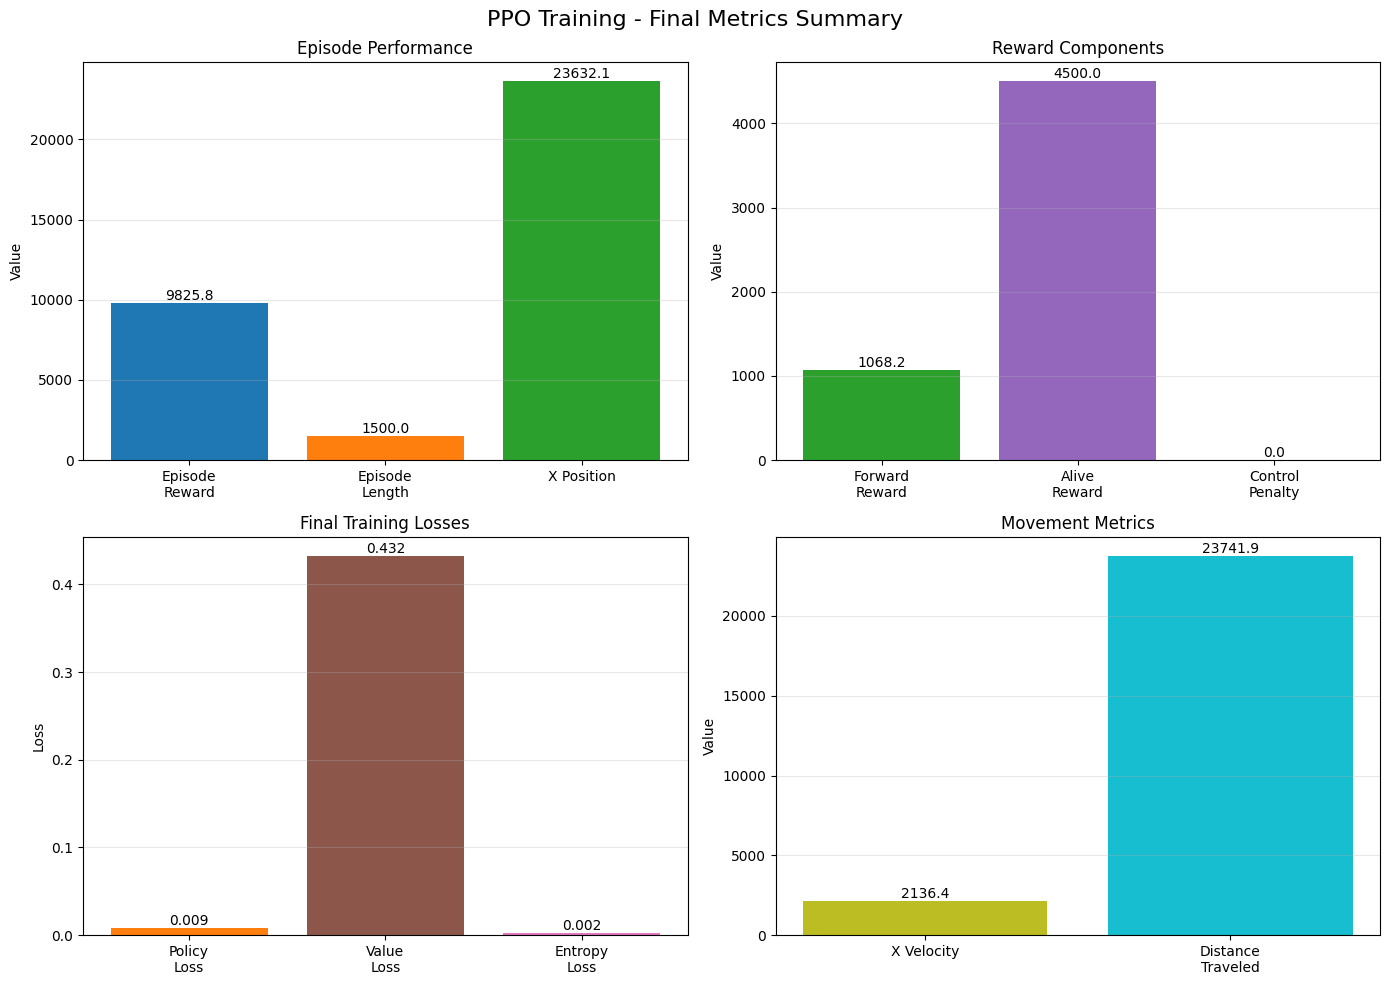


📊 All available metrics for parameter tuning:
  eval/avg_episode_length: 1500.0000
  eval/episode_distance_from_origin: 23741.9375
  eval/episode_distance_from_origin_std: 115.4811
  eval/episode_forward_reward: 1068.2034
  eval/episode_forward_reward_std: 4.4265
  eval/episode_posture_reward: 743.6642
  eval/episode_posture_reward_std: 2.3300
  eval/episode_reward: 9825.7812
  eval/episode_reward_alive: 4500.0000
  eval/episode_reward_alive_std: 0.0000
  eval/episode_reward_ctrl: -131.4956
  eval/episode_reward_ctrl_std: 0.8802
  eval/episode_reward_std: 6.3669
  eval/episode_smoothness_reward: 750.0000
  eval/episode_smoothness_reward_std: 0.0000
  eval/episode_velocity_reward: 2895.4102
  eval/episode_velocity_reward_std: 5.0021
  eval/episode_x_position: 23632.0977
  eval/episode_x_position_std: 119.4537
  eval/episode_x_velocity: 2136.4067
  eval/episode_x_velocity_std: 8.8529
  eval/epoch_eval_time: 15.2745
  eval/sps: 12569.9814
  eval/std_episode_length: 0.0000
  eval/walltime

In [38]:
# Plot Training Metrics

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

# First, let's check what data we actually have
print("Checking metrics data structure...")
array_metrics = {}
scalar_metrics = {}

for key, values in metrics.items():
    if hasattr(values, '__array__'):
        values = np.asarray(values)
    
    if isinstance(values, np.ndarray):
        if values.ndim > 0 and values.size > 1:
            array_metrics[key] = values
            print(f"  {key}: {values.shape} array")
        else:
            scalar_metrics[key] = float(values) if values.size == 1 else values
    else:
        scalar_metrics[key] = values

# If we have array metrics, plot them
if array_metrics:
    print(f"\n✓ Found {len(array_metrics)} metrics with time series data")
    
    # Create plots for array metrics
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('PPO Training Metrics Over Time', fontsize=16)
    
    # Plot up to 4 metrics
    plot_keys = list(array_metrics.keys())[:4]
    for idx, key in enumerate(plot_keys):
        ax = axes[idx // 2, idx % 2]
        data = array_metrics[key]
        ax.plot(data, linewidth=2)
        ax.set_xlabel('Step')
        ax.set_ylabel(key.split('/')[-1])
        ax.set_title(key)
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(plot_keys), 4):
        axes[idx // 2, idx % 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('training_metrics_timeseries.png', dpi=150)
    print("✓ Saved time series plot to 'training_metrics_timeseries.png'")
    plt.show()
else:
    print("\n⚠ No time series metrics found - only final scalar values available")
    print("Note: Training was configured with num_evals=10, but metrics may only store final values")

# Create a summary visualization of key final metrics
print("\n📊 Creating summary visualization of final metrics...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('PPO Training - Final Metrics Summary', fontsize=16)

# Plot 1: Episode Performance
ax1 = axes[0, 0]
performance_metrics = {
    'Episode\nReward': scalar_metrics.get('eval/episode_reward', 0),
    'Episode\nLength': scalar_metrics.get('eval/avg_episode_length', 0),
    'X Position': scalar_metrics.get('eval/episode_x_position', 0),
}
bars1 = ax1.bar(range(len(performance_metrics)), list(performance_metrics.values()), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax1.set_xticks(range(len(performance_metrics)))
ax1.set_xticklabels(list(performance_metrics.keys()))
ax1.set_title('Episode Performance')
ax1.set_ylabel('Value')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, performance_metrics.values())):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.1f}', 
             ha='center', va='bottom')

# Plot 2: Reward Components
ax2 = axes[0, 1]
reward_components = {
    'Forward\nReward': scalar_metrics.get('eval/episode_forward_reward', 0),
    'Alive\nReward': scalar_metrics.get('eval/episode_reward_alive', 0),
    'Control\nPenalty': scalar_metrics.get('eval/episode_reward_quadctrl', 0),
}
bars2 = ax2.bar(range(len(reward_components)), list(reward_components.values()), 
                color=['#2ca02c', '#9467bd', '#d62728'])
ax2.set_xticks(range(len(reward_components)))
ax2.set_xticklabels(list(reward_components.keys()))
ax2.set_title('Reward Components')
ax2.set_ylabel('Value')
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

for i, (bar, val) in enumerate(zip(bars2, reward_components.values())):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() if val >= 0 else 0, f'{val:.1f}', 
             ha='center', va='bottom' if val >= 0 else 'top')

# Plot 3: Training Losses
ax3 = axes[1, 0]
losses = {
    'Policy\nLoss': abs(scalar_metrics.get('training/policy_loss', 0)),
    'Value\nLoss': scalar_metrics.get('training/v_loss', 0),
    'Entropy\nLoss': abs(scalar_metrics.get('training/entropy_loss', 0)),
}
bars3 = ax3.bar(range(len(losses)), list(losses.values()), color=['#ff7f0e', '#8c564b', '#e377c2'])
ax3.set_xticks(range(len(losses)))
ax3.set_xticklabels(list(losses.keys()))
ax3.set_title('Final Training Losses')
ax3.set_ylabel('Loss')
ax3.grid(True, alpha=0.3, axis='y')

for i, (bar, val) in enumerate(zip(bars3, losses.values())):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.3f}', 
             ha='center', va='bottom')

# Plot 4: Speed Metrics
ax4 = axes[1, 1]
speed_metrics = {
    'X Velocity': scalar_metrics.get('eval/episode_x_velocity', 0),
    'Distance\nTraveled': scalar_metrics.get('eval/episode_distance_from_origin', 0),
}
bars4 = ax4.bar(range(len(speed_metrics)), list(speed_metrics.values()), color=['#bcbd22', '#17becf'])
ax4.set_xticks(range(len(speed_metrics)))
ax4.set_xticklabels(list(speed_metrics.keys()))
ax4.set_title('Movement Metrics')
ax4.set_ylabel('Value')
ax4.grid(True, alpha=0.3, axis='y')

for i, (bar, val) in enumerate(zip(bars4, speed_metrics.values())):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.1f}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=150)
print("✓ Saved training metrics summary to 'training_metrics.png'")
plt.show()

# Print all available metrics for parameter tuning reference
print("\n📊 All available metrics for parameter tuning:")
all_metrics = {**array_metrics, **scalar_metrics}
for key in sorted(all_metrics.keys()):
    values = all_metrics[key]
    if isinstance(values, np.ndarray) and values.size > 1:
        print(f"  {key}: {len(values)} points, final = {float(values[-1]):.4f}")
    else:
        try:
            print(f"  {key}: {float(values):.4f}")
        except:
            print(f"  {key}: {values}")